In [2]:
import os

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

**Seeing Folder Contents**

In [ ]:
for file in os.listdir(os.getcwd()):
  print(file)

queryid_tokensid.txt
purchasedkeywordid_tokensid.txt
titleid_tokensid.txt
descriptionid_tokensid.txt
userid_profile.txt
training.txt


**Loading Train Data**

In [9]:
column  = ['clicks', 'impressions', 'AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId']
train   = pd.read_csv('track2/training.txt', sep='\t', header=None, names=column,nrows = 5000000)
train.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


In [ ]:
train.iloc[:,:2].tail(10)

,clicks,impressions
4999990,0,1
4999991,0,1
4999992,0,1
4999993,0,1
4999994,0,1
4999995,0,1
4999996,0,1
4999997,0,1
4999998,0,1
4999999,0,1


**Observation** 

Clicks and impressions have have very few instances and we can't incur anything from them 
We smoothen values of clicks and impression in calculation of ctr , where:

pseudo-click  =  click + α × β

pseudo-impression=  impression + β

pseudo-ctr = pseudo-click / pseudo-impression

**Using  α = 0.05 and  β = 75**


In [ ]:

train['CTR'] = train['clicks'] * 1.0 / train['impressions']
train['RPosition'] = train['Depth'] - train['Pos'] * 1.0 / train['Depth']
train['pCTR'] = (1.0 * train['clicks'] + 0.05 * 75) / (train['impressions'] + 75)

train.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.000000,0.049342
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234,0.0,1.000000,0.049342
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234,0.0,2.000000,0.049342
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234,0.0,2.666667,0.049342
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234,0.0,0.000000,0.049342


**Loading test data**

In [10]:
column  = ['AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId']
test = pd.read_csv('test/test.txt', sep='\t', header=None, names=column, nrows = 1000000)

test.head()

,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId
0,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234
1,14340390157469404125,3111380,23777,3,1,6415,8872,62423,56167,490234
2,16772851793638846604,22111129,38584,3,2,6415,8872,454986,378040,490234
3,5325279403472852193,22166807,38756,2,1,83,34,5360,2080,490234
4,12057878999086460853,20180629,27961,2,2,83,34,328,455,490234


In [11]:
solution = pd.read_csv('KDD_Track2_solution.csv',  nrows=1000000)
solution.rename(columns = {'I clicks':'clicks'}, inplace = True)
solution = solution[['clicks', 'impressions']].copy()
solution.head()

,clicks,impressions
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [12]:
test = pd.concat([solution, test], axis=1)
test.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId
0,0,1,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234
1,0,1,14340390157469404125,3111380,23777,3,1,6415,8872,62423,56167,490234
2,0,1,16772851793638846604,22111129,38584,3,2,6415,8872,454986,378040,490234
3,0,1,5325279403472852193,22166807,38756,2,1,83,34,5360,2080,490234
4,0,1,12057878999086460853,20180629,27961,2,2,83,34,328,455,490234


In [ ]:
test['CTR'] = test['clicks'] * 1.0 / test['impressions']
test['RPosition'] = test['Depth'] - test['Pos'] * 1.0 / test['Depth']
test['pCTR'] = (1.0 * test['clicks'] + 0.05 * 75) / (test['impressions'] + 75)

test.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR
0,0,1,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234,0.0,2.000000,0.049342
1,0,1,14340390157469404125,3111380,23777,3,1,6415,8872,62423,56167,490234,0.0,2.666667,0.049342
2,0,1,16772851793638846604,22111129,38584,3,2,6415,8872,454986,378040,490234,0.0,2.333333,0.049342
3,0,1,5325279403472852193,22166807,38756,2,1,83,34,5360,2080,490234,0.0,1.500000,0.049342
4,0,1,12057878999086460853,20180629,27961,2,2,83,34,328,455,490234,0.0,1.000000,0.049342


**Loading Additional Data**

In [ ]:
user_col = ['UId', 'Gender', 'Age']
userid = pd.read_csv('userid_profile.txt', sep='\t', header=None, names=user_col)
userid.head()

,UId,Gender,Age
0,1,1,5
1,2,2,3
2,3,1,5
3,4,1,3
4,5,2,1


In [ ]:
title_col = ['TitleId', 'Title']
ad_title = pd.read_csv('titleid_tokensid.txt', sep='\t', header=None, names=title_col)
ad_title.head()

,TitleId,Title
0,0,615|1545|75|31|1|138|1270|615|131
1,1,466|582|685|1|42|45|477|314
2,2,12731|190|513|12731|677|183
3,3,2371|3970|1|2805|4340|3|2914|10640|3688|11|834|3
4,4,165|134|460|2887|50|2|17527|1|1540|592|2181|3|...


In [ ]:
desc_col  = ['DescId', 'Description']
ad_desc= pd.read_csv('descriptionid_tokensid.txt', sep='\t', header=None, names=desc_col)
ad_desc.head()

,DescId,Description
0,0,1545|31|40|615|1|272|18889|1|220|511|20|5270|1...
1,1,172|46|467|170|5634|5112|40|155|1965|834|21|41...
2,2,2672|6|1159|109662|123|49933|160|848|248|207|1...
3,3,13280|35|1299|26|282|477|606|1|4016|1671|771|1...
4,4,13327|99|128|494|2928|21|26500|10|11733|10|318...


In [ ]:
key_col  = ['KeyId', 'Keyword']
keyword_data  = pd.read_csv('purchasedkeywordid_tokensid.txt', sep='\t', header=None, names=key_col)
keyword_data.head()

,KeyId,Keyword
0,0,12731
1,1,1545
2,2,477
3,3,1545|75|31
4,4,279


In [ ]:
query_col = ['QId', 'Query']
query_data= pd.read_csv('queryid_tokensid.txt', sep='\t', header=None, names=query_col)
query_data.head()


,QId,Query
0,0,12731
1,1,1545|75|31
2,2,383
3,3,518|1996
4,4,4189|75|31


**Cleaning Additional data**

In [ ]:
def count(sen):
  return len(str(sen.split('|'))) 

In [ ]:
query_data['QCount'] = query_data['Query'].apply(count)
del query_data['Query']

# Count no. of tokens in title of an advertisement

ad_title['TCount'] = ad_title['Title'].apply(count)
del ad_title['Title']

# Count no. of tokens in description of an advertisement.

ad_desc['DCount'] = ad_desc['Description'].apply(count)
del ad_desc['Description']

# Count no. of tokens in purchased keyword.

keyword_data['KCount'] = keyword_data['Keyword'].apply(count)
del keyword_data['Keyword']

In [ ]:
train = pd.merge(train, userid,  on='UId')
train = pd.merge(train, query_data, on='QId')
train = pd.merge(train, ad_title, on='TitleId')
train = pd.merge(train, ad_desc,  on='DescId')
train = pd.merge(train, keyword_data, on='KeyId')

train.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender_x,Age_x,QCount_x,Gender_y,Age_y,QCount_y,TCount_x,Gender,Age,QCount,TCount_y,DCount,KCount
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.0,0.049342,1,3,8,1,3,8,54,1,3,8,54,131,20
1,0,2,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,30161,0.0,1.0,0.048701,1,3,8,1,3,8,54,1,3,8,54,131,20
2,0,1,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,1873171,0.0,1.0,0.049342,2,5,8,2,5,8,54,2,5,8,54,131,20
3,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,6558374,0.0,2.0,0.049342,0,2,8,0,2,8,54,0,2,8,54,131,20
4,0,2,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,1566180,0.0,2.0,0.048701,2,5,8,2,5,8,54,2,5,8,54,131,20


In [ ]:
train.to_csv('trainDataP.csv')

In [ ]:
test = pd.merge(test, userid,  on='UId')
test = pd.merge(test, query_data, on='QId')
test = pd.merge(test, ad_title, on='TitleId')
test = pd.merge(test, ad_desc,  on='DescId')
test = pd.merge(test, keyword_data, on='KeyId')

test.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender,Age,QCount,TCount,DCount,KCount
0,0,1,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234,0.0,2.0,0.049342,1,3,8,89,173,6
1,0,1,5325279403472852193,22166806,38756,3,3,4902,34,3341,2080,15900,0.0,2.0,0.049342,1,5,14,89,173,6
2,0,1,5325279403472852193,22166806,38756,2,2,308,34,3341,2080,302714,0.0,1.0,0.049342,2,3,13,89,173,6
3,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,2235546,0.0,2.0,0.049342,1,3,13,89,173,6
4,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,111500,0.0,2.0,0.049342,1,4,13,89,173,6


In [ ]:
test.to_csv('testDataP.csv')

In [ ]:
test=pd.read_csv('testDataP.csv',index_col=0)
train=pd.read_csv('trainDataP.csv',index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Converting Categorical features into Rates

In [ ]:
n=[12,14]
for i in range(2,17):
  if i in n:
    pass
  else:
    print('Number of Unique Values of ',(train.iloc[:,i]).name,'are : ',len(train.iloc[:,i].value_counts()))

Number of Unique Values of  AdURL are :  20919
Number of Unique Values of  AdId are :  212422
Number of Unique Values of  AdvId are :  13921
Number of Unique Values of  Depth are :  3
Number of Unique Values of  Pos are :  3
Number of Unique Values of  QId are :  1155690
Number of Unique Values of  KeyId are :  269366
Number of Unique Values of  TitleId are :  626092
Number of Unique Values of  DescId are :  503825
Number of Unique Values of  UId are :  971492
Number of Unique Values of  RPosition are :  6
Number of Unique Values of  Gender_x are :  3
Number of Unique Values of  Age_x are :  6


**Adding Mean of Features according to CTR and PCTR**

In [ ]:
avg_ctr = {}
avg_pctr = {}

def add(dataset, key, label, col, op):
    temp = dataset
    
    result = temp.groupby(key).agg([op])
    index  = result.index
    ctr    = result.get_values()
    
    temp = pd.DataFrame()
    temp[key] = index
    temp[label] = ctr
    if col=='CTR':
        avg_ctr[label]=np.mean(ctr)
    elif col == 'pCTR':
        avg_pctr[label]=np.mean(ctr)
        
    return temp


def addfeatures(dataset, train, keys, labels, col, op):
     for key in keys:
        temp = train[[key, col]]
        temp = add(temp, key, labels[key], col, op)
        dataset = pd.merge(dataset, temp, on=key, how='left')
     return dataset

### Train Data :

In [ ]:
keys = ['AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId', 'Gender', 'Age','RPosition']
labels = {'AdURL':'mAdURL', 'AdId':'mAdCTR', 'AdvId':'mAdvCTR', 'Depth':'mDepthCTR', 'Pos':'mPosCTR', 'QId':'mQId', 
          'KeyId':'mKeyId', 'TitleId':'mTitleId', 'DescId':'mDescId', 'UId':'mUId', 'Gender': 'mGender', 'Age':'mAge','RPosition':'mRPosition'}

train_updated = addfeatures(train,train, keys, labels, 'CTR', 'mean')
train_updated.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender_x,Age_x,QCount_x,Gender_y,Age_y,QCount_y,TCount_x,Gender,Age,QCount,TCount_y,DCount,KCount,mAdURL,mAdCTR,mAdvCTR,mDepthCTR,mPosCTR,mQId,mKeyId,mTitleId,mDescId,mUId,mGender,mAge,mRPosition
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.0,0.049342,1,3,8,1,3,8,54,1,3,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.000000,0.044093,0.043846,0.018944
1,0,2,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,30161,0.0,1.0,0.048701,1,3,8,1,3,8,54,1,3,8,54,131,20,0.051432,0.024,0.051432,0.047993,0.030773,0.040284,0.025974,0.024,0.038875,0.007246,0.044093,0.043846,0.031384
2,0,1,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,1873171,0.0,1.0,0.049342,2,5,8,2,5,8,54,2,5,8,54,131,20,0.051432,0.024,0.051432,0.047993,0.030773,0.040284,0.025974,0.024,0.038875,0.000000,0.045860,0.047465,0.031384
3,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,6558374,0.0,2.0,0.049342,0,2,8,0,2,8,54,0,2,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.000000,0.045276,0.045257,0.018944
4,0,2,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,1566180,0.0,2.0,0.048701,2,5,8,2,5,8,54,2,5,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.130952,0.045860,0.047465,0.018944


In [ ]:
keys = ['AdURL', 'AdId', 'AdvId', 'Depth', 'Pos', 'QId', 'KeyId', 'TitleId', 'DescId', 'UId', 'Gender', 'Age','RPosition']
labels = {'AdURL':'pAdURL', 'AdId':'pAdCTR', 'AdvId':'pAdvCTR', 'Depth':'pDepthCTR', 'Pos':'pPosCTR', 'QId':'pQId', 
          'KeyId':'pKeyId', 'TitleId':'pTitleId', 'DescId':'pDescId', 'UId':'pUId', 'Gender': 'pGender', 'Age':'pAge','RPosition':'pRPosition'}

train_updated = addfeatures(train_updated,train, keys, labels, 'pCTR', 'mean')
train_updated.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender_x,Age_x,QCount_x,Gender_y,Age_y,QCount_y,TCount_x,Gender,Age,QCount,TCount_y,DCount,KCount,mAdURL,mAdCTR,mAdvCTR,mDepthCTR,mPosCTR,mQId,mKeyId,mTitleId,mDescId,mUId,mGender,mAge,mRPosition,pAdURL,pAdCTR,pAdvCTR,pDepthCTR,pPosCTR,pQId,pKeyId,pTitleId,pDescId,pUId,pGender,pAge,pRPosition
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234,0.0,2.0,0.049342,1,3,8,1,3,8,54,1,3,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.000000,0.044093,0.043846,0.018944,0.049939,0.049546,0.049939,0.049733,0.049501,0.049798,0.049585,0.049546,0.049729,0.049342,0.049856,0.049863,0.049501
1,0,2,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,30161,0.0,1.0,0.048701,1,3,8,1,3,8,54,1,3,8,54,131,20,0.051432,0.024,0.051432,0.047993,0.030773,0.040284,0.025974,0.024,0.038875,0.007246,0.044093,0.043846,0.031384,0.049939,0.049546,0.049939,0.049929,0.049677,0.049798,0.049585,0.049546,0.049729,0.049368,0.049856,0.049863,0.049689
2,0,1,4298118681424644510,7686695,385,2,2,1601,5521,7709,576,1873171,0.0,1.0,0.049342,2,5,8,2,5,8,54,2,5,8,54,131,20,0.051432,0.024,0.051432,0.047993,0.030773,0.040284,0.025974,0.024,0.038875,0.000000,0.045860,0.047465,0.031384,0.049939,0.049546,0.049939,0.049929,0.049677,0.049798,0.049585,0.049546,0.049729,0.049289,0.049904,0.049916,0.049689
3,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,6558374,0.0,2.0,0.049342,0,2,8,0,2,8,54,0,2,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.000000,0.045276,0.045257,0.018944,0.049939,0.049546,0.049939,0.049733,0.049501,0.049798,0.049585,0.049546,0.049729,0.049342,0.049889,0.049889,0.049501
4,0,2,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,1566180,0.0,2.0,0.048701,2,5,8,2,5,8,54,2,5,8,54,131,20,0.051432,0.024,0.051432,0.035616,0.018944,0.040284,0.025974,0.024,0.038875,0.130952,0.045860,0.047465,0.018944,0.049939,0.049546,0.049939,0.049733,0.049501,0.049798,0.049585,0.049546,0.049729,0.051716,0.049904,0.049916,0.049501


### Test Data :

In [ ]:
test_updated = addfeatures(test,train, keys, labels, 'CTR', 'mean')
test_updated.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender,Age,QCount,TCount,DCount,KCount,pAdURL,pAdCTR,pAdvCTR,pDepthCTR,pPosCTR,pQId,pKeyId,pTitleId,pDescId,pUId,pGender,pAge,pRPosition
0,0,1,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234,0.0,2.0,0.049342,1,3,8,89,173,6,0.056452,0.0,0.085479,0.035616,0.018944,0.000000,0.031357,0.0,0.05,0.000000,0.044093,0.043846,0.018944
1,0,1,5325279403472852193,22166806,38756,3,3,4902,34,3341,2080,15900,0.0,2.0,0.049342,1,5,14,89,173,6,0.056452,0.0,0.085479,0.035616,0.018944,0.075758,0.031357,0.0,0.05,0.007576,0.044093,0.047465,0.018944
2,0,1,5325279403472852193,22166806,38756,2,2,308,34,3341,2080,302714,0.0,1.0,0.049342,2,3,13,89,173,6,0.056452,0.0,0.085479,0.047993,0.030773,0.080735,0.031357,0.0,0.05,0.304348,0.045860,0.043846,0.031384
3,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,2235546,0.0,2.0,0.049342,1,3,13,89,173,6,0.056452,0.0,0.085479,0.035616,0.018944,0.080735,0.031357,0.0,0.05,NaN,0.044093,0.043846,0.018944
4,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,111500,0.0,2.0,0.049342,1,4,13,89,173,6,0.056452,0.0,0.085479,0.035616,0.018944,0.080735,0.031357,0.0,0.05,NaN,0.044093,0.042321,0.018944


In [ ]:
test_updated.isnull().sum()

clicks              0
impressions         0
AdURL               0
AdId                0
AdvId               0
Depth               0
Pos                 0
QId                 0
KeyId               0
TitleId             0
DescId              0
UId                 0
CTR                 0
RPosition           0
pCTR                0
Gender              0
Age                 0
QCount              0
TCount              0
DCount              0
KCount              0
pAdURL          32900
pAdCTR          87306
pAdvCTR         28914
pDepthCTR           0
pPosCTR             0
pQId           355645
pKeyId          48754
pTitleId       210667
pDescId        172196
pUId           629664
pGender             0
pAge                0
pRPosition          0
dtype: int64

In [ ]:
test_updated=test_updated.fillna(avg_ctr)

In [ ]:
test_updated = addfeatures(test,train, keys, labels, 'pCTR', 'mean')
test_updated.head()

,clicks,impressions,AdURL,AdId,AdvId,Depth,Pos,QId,KeyId,TitleId,DescId,UId,CTR,RPosition,pCTR,Gender,Age,QCount,TCount,DCount,KCount,pAdURL,pAdCTR,pAdvCTR,pDepthCTR,pPosCTR,pQId,pKeyId,pTitleId,pDescId,pUId,pGender,pAge,pRPosition
0,0,1,5325279403472852193,22166806,38756,3,3,6415,34,3341,2080,490234,0.0,2.0,0.049342,1,3,8,89,173,6,0.049962,0.048851,0.050462,0.049733,0.049501,0.049330,0.049707,0.048397,0.049889,0.049342,0.049856,0.049863,0.049501
1,0,1,5325279403472852193,22166806,38756,3,3,4902,34,3341,2080,15900,0.0,2.0,0.049342,1,5,14,89,173,6,0.049962,0.048851,0.050462,0.049733,0.049501,0.050271,0.049707,0.048397,0.049889,0.049342,0.049856,0.049916,0.049501
2,0,1,5325279403472852193,22166806,38756,2,2,308,34,3341,2080,302714,0.0,1.0,0.049342,2,3,13,89,173,6,0.049962,0.048851,0.050462,0.049929,0.049677,0.050383,0.049707,0.048397,0.049889,0.053263,0.049904,0.049863,0.049689
3,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,2235546,0.0,2.0,0.049342,1,3,13,89,173,6,0.049962,0.048851,0.050462,0.049733,0.049501,0.050383,0.049707,0.048397,0.049889,NaN,0.049856,0.049863,0.049501
4,0,1,5325279403472852193,22166806,38756,3,3,308,34,3341,2080,111500,0.0,2.0,0.049342,1,4,13,89,173,6,0.049962,0.048851,0.050462,0.049733,0.049501,0.050383,0.049707,0.048397,0.049889,NaN,0.049856,0.049835,0.049501


In [ ]:
test_updated.isnull().sum()

clicks              0
impressions         0
AdURL               0
AdId                0
AdvId               0
Depth               0
Pos                 0
QId                 0
KeyId               0
TitleId             0
DescId              0
UId                 0
CTR                 0
RPosition           0
pCTR                0
Gender              0
Age                 0
QCount              0
TCount              0
DCount              0
KCount              0
pAdURL          32900
pAdCTR          87306
pAdvCTR         28914
pDepthCTR           0
pPosCTR             0
pQId           355645
pKeyId          48754
pTitleId       210667
pDescId        172196
pUId           629664
pGender             0
pAge                0
pRPosition          0
dtype: int64

In [ ]:
test_updated=test_updated.fillna(avg_pctr)

In [ ]:
test_updated.isnull().sum()

clicks         0
impressions    0
AdURL          0
AdId           0
AdvId          0
Depth          0
Pos            0
QId            0
KeyId          0
TitleId        0
DescId         0
UId            0
CTR            0
RPosition      0
pCTR           0
Gender         0
Age            0
QCount         0
TCount         0
DCount         0
KCount         0
pAdURL         0
pAdCTR         0
pAdvCTR        0
pDepthCTR      0
pPosCTR        0
pQId           0
pKeyId         0
pTitleId       0
pDescId        0
pUId           0
pGender        0
pAge           0
pRPosition     0
dtype: int64

In [ ]:
train_updated.to_csv('TRAINING_DATA.csv')
test_updated.to_csv('TEST_DATA.csv')

In [11]:
print(os.listdir(os.getcwd()))

['queryid_tokensid.txt', 'purchasedkeywordid_tokensid.txt', 'titleid_tokensid.txt', 'descriptionid_tokensid.txt', 'userid_profile.txt', 'training.txt', 'test.txt', 'kaggle.json', 'KDD_Track2_solution.csv', 'testdata', 'trainDataP.csv', 'testDataP.csv', 'TRAINING_DATA.csv', 'TEST_DATA.csv']


In [5]:
train_updated=pd.read_csv('TRAINING_DATA.csv')
test_updated=pd.read_csv('TEST_DATA.csv')

In [6]:
train_x = train_updated[['pAdURL','pAdCTR', 'pAdvCTR','pPosCTR','pQId', 
          'pKeyId', 'pTitleId', 'pDescId','pUId','pGender','pAge','pRPosition']].copy()
train_y = train_updated[['CTR']].copy()

In [7]:
test_x = test_updated[['pAdURL','pAdCTR', 'pAdvCTR','pPosCTR','pQId', 
          'pKeyId', 'pTitleId', 'pDescId','pUId','pGender','pAge','pRPosition']].copy()

test_y = test_updated[['CTR']].copy()

### Perfomance Metrics

- AUC
***

**Calculating AUC :**

In [16]:
def auc(num_clicks, num_impressions, predicted_ctr):

     #sorting the values in descending order and store the index
    i_sorted = sorted(range(len(predicted_ctr)),key=lambda i: predicted_ctr[i],
                      reverse=True)
    auc_temp = 0.0
    click_sum = 0.0
    old_click_sum = 0.0
    no_click = 0.0
    no_click_sum = 0.0

    # treat all instances with the same predicted_ctr as coming from the same bucket
    last_ctr = predicted_ctr[i_sorted[0]] + 1.0

    for i in range(len(predicted_ctr)):
        # when prev_ctr value at i-1 not match with current ctr value at i
        if last_ctr != predicted_ctr[i_sorted[i]]: 
            auc_temp += (click_sum+old_click_sum) * no_click / 2.0        
            old_click_sum = click_sum
            no_click = 0.0
            last_ctr = predicted_ctr[i_sorted[i]] #updating the last ctr value 
        # Calculating negative sample as #impressions - #clicks    
        no_click += num_impressions[i_sorted[i]] - num_clicks[i_sorted[i]]
        no_click_sum += num_impressions[i_sorted[i]] - num_clicks[i_sorted[i]]
        # Calculating postive samples as # of clicks 
        click_sum += num_clicks[i_sorted[i]]
    auc_temp += (click_sum+old_click_sum) * no_click / 2.0
    auc = auc_temp / (click_sum * no_click_sum) # That is the scaling to a total area of 1
    return auc

## Using Xgboost

In [35]:
%%time

regr = xgb.XGBRegressor(max_depth= 2, min_samples_split= 2,learning_rate=0.01,n_estimators =500, verbose=1)
regr.fit(train_x, train_y)
y_pred_test = regr.predict(test_x)
y_pred_train = regr.predict(train_x)
print('-'*50)
 
roc_auct = auc(train['clicks'],train['impressions'],y_pred_train)
print("Train auc with esimators = 500 is ", roc_auc)


roc_aucte = auc(test['clicks'],test['impressions'],y_pred_test)
print("Test with esimators = 500 is ", roc_auc) 



[18:13:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:13:40] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
--------------------------------------------------
Train auc with esimators = 500 is  0.4988958892091562
Test with esimators = 500 is  0.4988958892091562
Wall time: 59min 50s


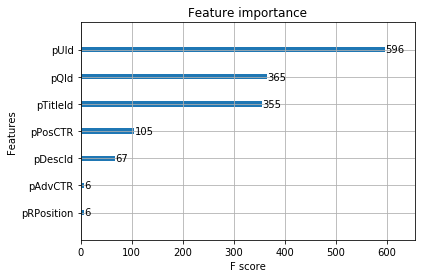

In [39]:
from xgboost import plot_importance
plot_importance(regr)
plt.show()